# Accuracy Report
This notebook provides a visual analysis of the extraction accuracy compared to the ground truth across multiple documents.

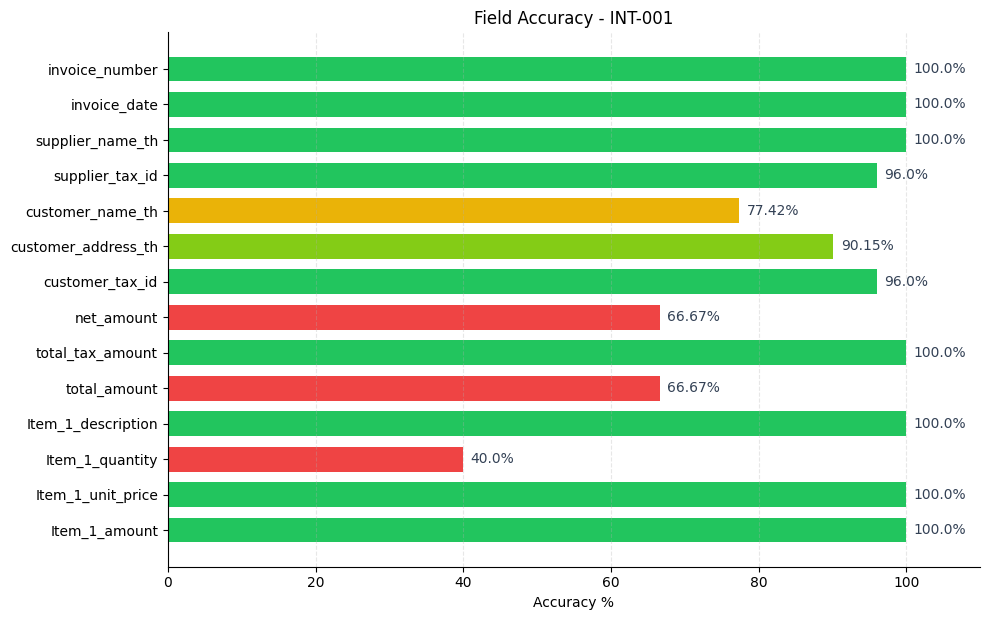

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,100.00%,25102400095,25102400095,Header
1,invoice_date,100.00%,24/10/2025,24/10/2025,Header
2,supplier_name_th,100.00%,บริษัท อินเทอร์เน็ตประเทศไทย จำกัด (มหาชน),บริษัท อินเทอร์เน็ตประเทศไทย จำกัด (มหาชน),Header
3,supplier_tax_id,96.00%,0107544000094,010754400094,Header
4,customer_name_th,77.42%,บจก. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บจก. อินเทอร์เน็ต เอ็กซ์ตรีมิสต์,Header
5,customer_address_th,90.15%,เลขที่ 3 อาคาร พร้อมพันธุ์ 3 ห้องเลขที่ 1608-1614 ชั้นที่ 16 ซอย ลาดพร้าว 3 ถนน ลาดพร้าว แขวง จอมพล เขต จตุจักร กรุงเทพมหานคร 10900,เลขที่ 3 อาคาร พร้อมพื้นที่ 3 ห้องเลขที่ 1608-1614 ชั้นที่ 16 ซอย ลาดพร้าว 3 ถนน สาทรรัตน์ แขวง จอมพล เขต จตุจักร กรุงเทพมหานคร 10900,Header
6,customer_tax_id,96.00%,0105551117714,010551117714,Header
7,net_amount,66.67%,600.00,642.00,Header
8,total_tax_amount,100.00%,42.00,42.00,Header
9,total_amount,66.67%,642.00,600.00,Header


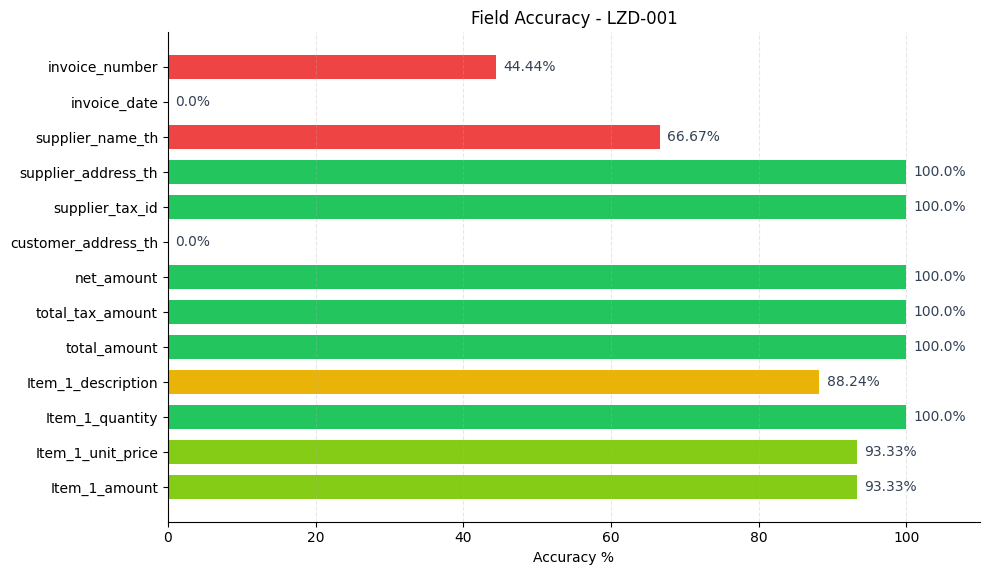

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,44.44%,IN0018918431,649344100179434,Header
1,invoice_date,0.00%,26/01/2023,,Header
2,supplier_name_th,66.67%,LAZADA LIMITED,LAZADA LIMITED (HEAD OFFICE),Header
3,supplier_address_th,100.00%,"29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton, Vadhana, Bangkok, 10110","29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton, Vadhana, Bangkok, 10110",Header
4,supplier_tax_id,100.00%,0105555040244,0105555040244,Header
5,customer_address_th,0.00%,"กรุงเทพมหานคร/ Bangkok, 10230",,Header
6,net_amount,100.00%,"1,269.00","1,269.00",Header
7,total_tax_amount,100.00%,83.02,83.02,Header
8,total_amount,100.00%,"1,269.00","1,269.00",Header
9,Item_1_description,88.24%,Certainty ผ้าอ้อมผู้ใหญ่แบบเทป เซอร์เทนตี้ อีซี่เทป Easy Tapeราคาประหยัด ลัง Super Save ไซส์ L 96 ชิ้น,Certainty ผ้าอ้อมผู้ใหญ่แบบแท่ง เชอร์เทนส์ อีซี่เทป Easy Taperedประหยัด สิ้ง Super Save ไซส์ L 96 ชิ้น,Line Item


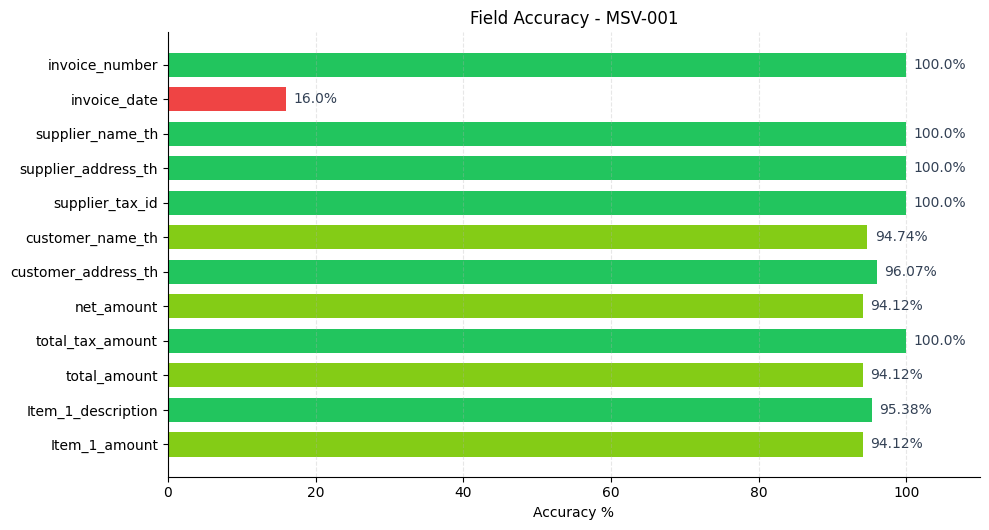

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,100.00%,M68/393,M68/393,Header
1,invoice_date,16.00%,17 กันยายน 2568,2025-09-17,Header
2,supplier_name_th,100.00%,บริษัท เอ็ม-เซเว่น (ประเทศไทย) จำกัด,บริษัท เอ็ม-เซเว่น (ประเทศไทย) จำกัด,Header
3,supplier_address_th,100.00%,"309, 311 ซอยอ่อนนุช 70/1 ถนนอ่อนนุช แขวงประเวศ เขตประเวศ กรุงเทพฯ 10250","309, 311 ซอยอ่อนนุช 70/1 ถนนอ่อนนุช แขวงประเวศ เขตประเวศ กรุงเทพฯ 10250",Header
4,supplier_tax_id,100.00%,0105530029573,0105530029573,Header
5,customer_name_th,94.74%,บริษัท อินโนเวทีฟ เอ็กซ์ตรีมิสต์ จำกัด,บริษัท อินโนเวทีฟ เอ็กซ์ตริมิตส์ จำกัด,Header
6,customer_address_th,96.07%,3 อาคารพร้อมพันธุ์ 3 ชั้นที่ 16 ห้องเลขที่ 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900,3 อาคารพร้อมพื้นที่ 3 ชั้นที่ 16 ห้องเลขที่ 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900,Header
7,net_amount,94.12%,"11,214.95",11214.95,Header
8,total_tax_amount,100.00%,785.05,785.05,Header
9,total_amount,94.12%,"12,000.00",12000.00,Header


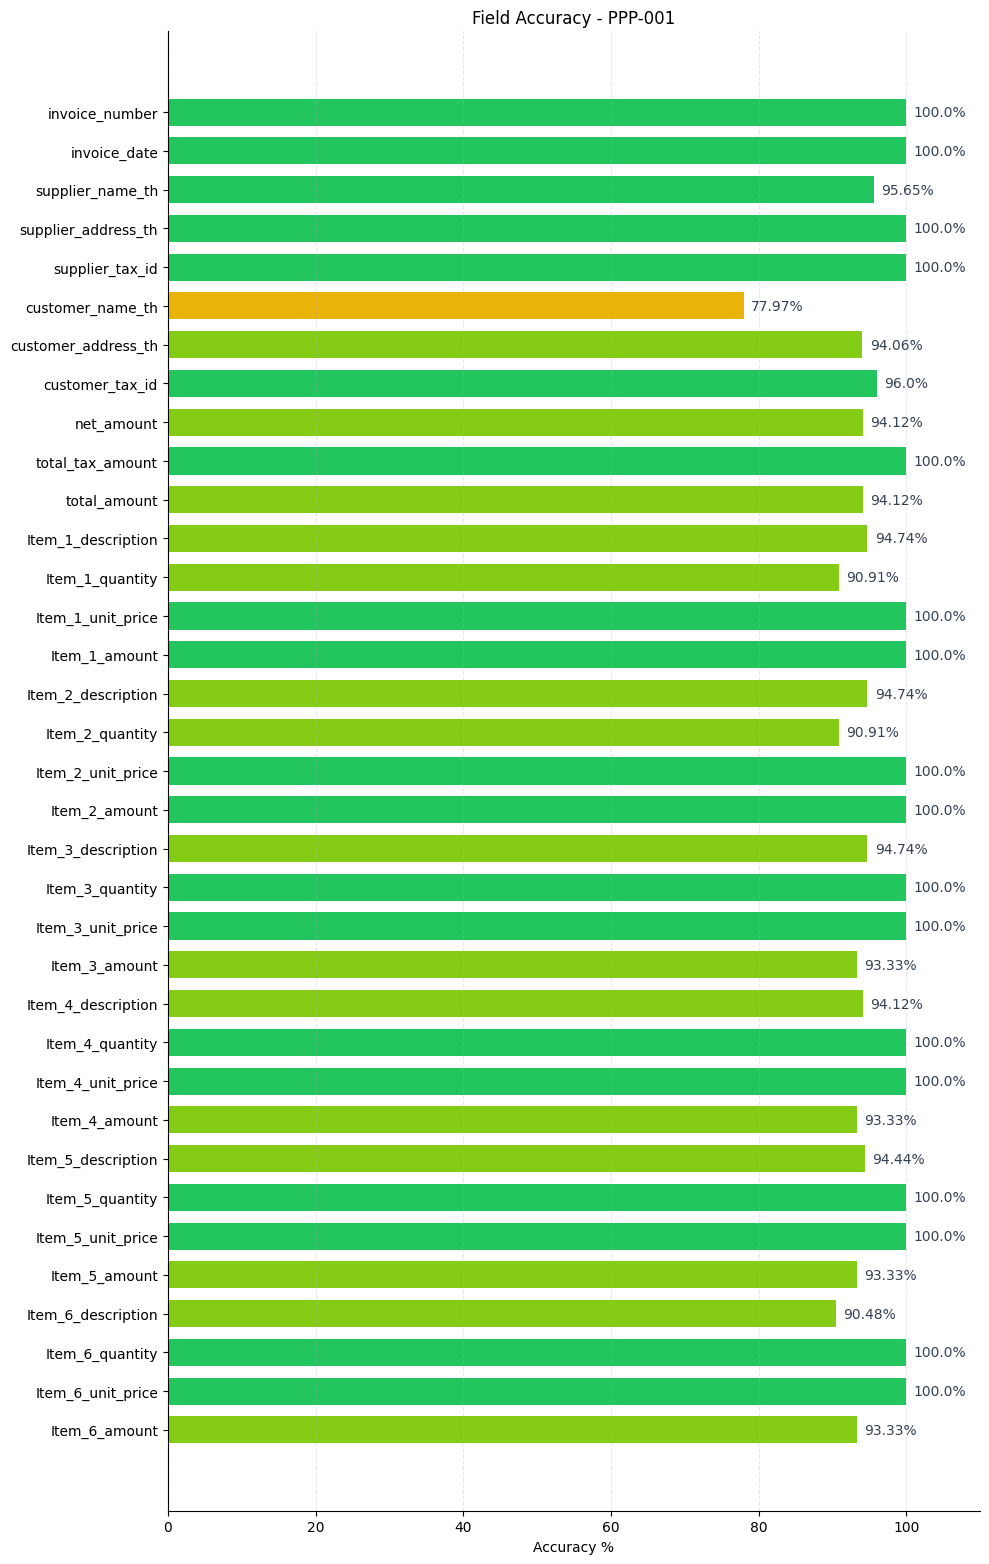

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,100.00%,R36810186,R36810186,Header
1,invoice_date,100.00%,07/10/68,07/10/68,Header
2,supplier_name_th,95.65%,บริษัท เพิ่มพูล ประสิทธิ์-ตุ๊ จำกัด,บริษัท เพิ่มพูล ประสิทธิ์-ตี จำกัด,Header
3,supplier_address_th,100.00%,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900,Header
4,supplier_tax_id,100.00%,0105534071621,0105534071621,Header
5,customer_name_th,77.97%,บจก. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บอค. อินโนเวสท์ เอกซ์ตริมิตส์,Header
6,customer_address_th,94.06%,3 อาคารพร้อมพันธุ์ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,อาคารพร้อมพื้นที่ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,Header
7,customer_tax_id,96.00%,0105551117714,010555117714,Header
8,net_amount,94.12%,"11,985.35",11985.35,Header
9,total_tax_amount,100.00%,838.97,838.97,Header


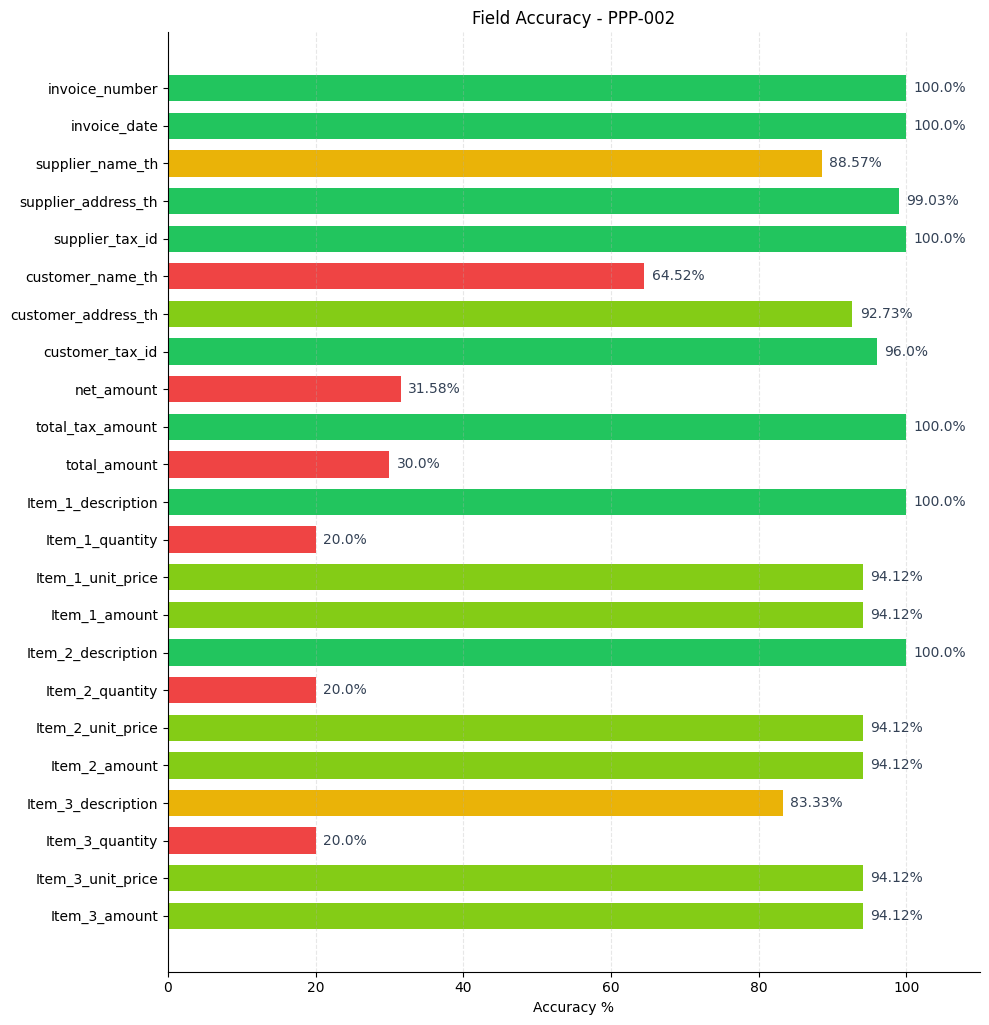

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,100.00%,R36810185,R36810185,Header
1,invoice_date,100.00%,07/10/68,07/10/68,Header
2,supplier_name_th,88.57%,บริษัท เพิ่มพูล ประสิทธิ์-ตุ๊ จำกัด,บริษัท เพิ่มพูด ประสิทธิ์-คู่ จำกัด,Header
3,supplier_address_th,99.03%,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900.,Header
4,supplier_tax_id,100.00%,0105534071621,0105534071621,Header
5,customer_name_th,64.52%,บจก. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,มอช. อินโนเวสท์ เอ็กซ์เพรเมียนท์,Header
6,customer_address_th,92.73%,3 อาคารพร้อมพันธุ์ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว เเขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,อาคารพร้อมพื้นที่ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,Header
7,customer_tax_id,96.00%,0105551117714,010551117714,Header
8,net_amount,31.58%,"46,700.30","130,413.32",Header
9,total_tax_amount,100.00%,"3,269.02","3,269.02",Header


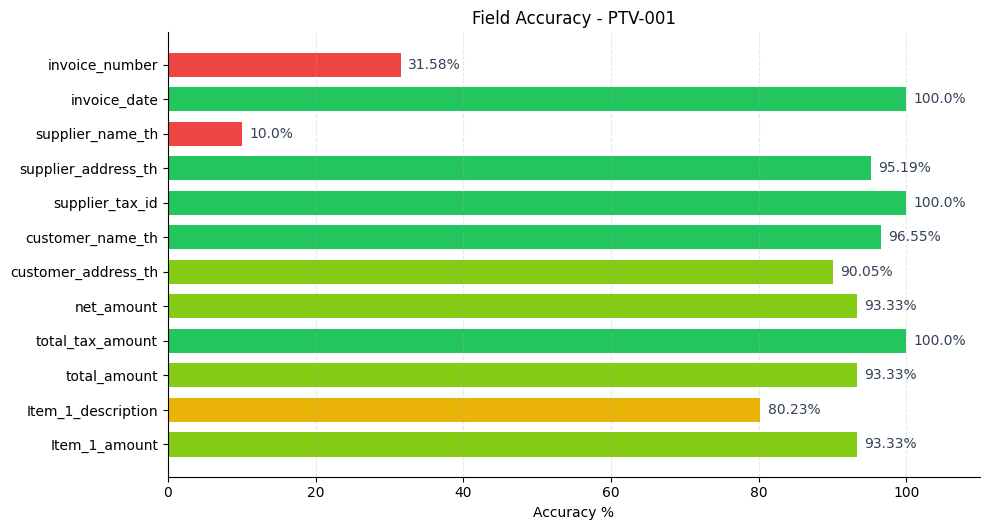

,Field,Accuracy,Ground Truth,Result,Category
0,invoice_number,31.58%,68101365,RCA25019646,Header
1,invoice_date,100.00%,24/10/2025,24/10/2025,Header
2,supplier_name_th,10.00%,บริษัท พันธวณิช จำกัด,"Pantavani Co., Ltd.",Header
3,supplier_address_th,95.19%,1168/94 อาคารลุมพินีทาวเวอร์ ชั้น 31 ถนนพระราม 4 แขวงทุ่งมหาเมฆ เขตสาทร กรุงเทพมหานคร 10120,1168/94 อาคารอุปถัมภ์ฟินีทาวเวอร์ ชั้น 31 ถนนพระราม 4 แขวงทุ่งมหาเมฆ เขตสาทร กรุงเทพมหานคร 10120,Header
4,supplier_tax_id,100.00%,0105544028248,0105544028248,Header
5,customer_name_th,96.55%,บจ. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บจ. อินโนเวทีฟ เอ็กซ์ตรีมิตส์,Header
6,customer_address_th,90.05%,3 อาคารพร้อมพันธุ์ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถน นลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900,3 อาคารพร้อมพื้นที่ ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาภาพราว แขวงแย้มพล เขตจตุจักร กรุงเทพฯ 10900,Header
7,net_amount,93.33%,"1,740.00",1740.00,Header
8,total_tax_amount,100.00%,121.80,121.80,Header
9,total_amount,93.33%,"1,861.80",1861.80,Header


In [13]:
import json
import difflib
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Global list to store summary results
batch_summary = []

def calculate_accuracy(str1, str2):
    str1 = str(str1).strip()
    str2 = str(str2).strip()
    if not str1 and not str2:
        return 100.0
    matcher = difflib.SequenceMatcher(None, str1, str2)
    return round(matcher.ratio() * 100, 2)

def get_comparison_data(gt_path, res_path):
    with open(gt_path, 'r', encoding='utf-8') as f:
        gt = json.load(f)
    with open(res_path, 'r', encoding='utf-8') as f:
        res = json.load(f)

    data = []
    
    # Top-level fields
    for key in gt.keys():
        if key == 'line_items': continue
        val_gt = gt.get(key)
        val_res = res.get(key, "")
        
        if not val_gt or str(val_gt).strip() == "":
            continue
            
        acc = calculate_accuracy(val_gt, val_res)
        data.append({"Field": key, "Accuracy": acc, "Ground Truth": val_gt, "Result": val_res, "Category": "Header"})

    # Line items
    gt_items = gt.get('line_items', [])
    res_items = res.get('line_items', [])
    for i, item_gt in enumerate(gt_items):
        item_res = res_items[i] if i < len(res_items) else {}
        for k, v_gt in item_gt.items():
            if not v_gt or str(v_gt).strip() == "": continue
            v_res = item_res.get(k, "")
            acc = calculate_accuracy(v_gt, v_res)
            data.append({"Field": f"Item_{i+1}_{k}", "Accuracy": acc, "Ground Truth": v_gt, "Result": v_res, "Category": "Line Item"})
            
    return pd.DataFrame(data)

def generate_visual_report(df, filename):
    if df.empty:
        print(f"No data to report for {filename}.")
        return

    overall_acc = df['Accuracy'].mean()
    
    # Store in summary
    batch_summary.append({"File": filename, "Score": overall_acc, "Fields": len(df)})

    display(HTML(f"<h1 style='border-bottom: 2px solid #334155; padding-bottom: 10px; margin-top: 50px;'>Report: {filename}</h1>"))

    # 1. Summary Card
    summary_html = f"""
    <div style="padding: 20px; border-radius: 10px; background-color: #f8fafc; border-left: 8px solid #4CAF50; margin-bottom: 24px; box-shadow: 0 4px 6px -1px rgb(0 0 0 / 0.1);">
        <h2 style="margin: 0; color: #1e293b; font-family: sans-serif;">Extraction Accuracy Summary</h2>
        <div style="display: flex; align-items: center; margin-top: 12px;">
            <span style="font-size: 16px; color: #64748b; margin-right: 8px;">Overall Score:</span>
            <span style="color: #16a34a; font-size: 28px; font-weight: bold;">{overall_acc:.2f}%</span>
        </div>
        <p style="margin: 8px 0 0 0; color: #64748b; font-size: 14px;">Total Fields Evaluated: <b style="color: #334155;">{len(df)}</b></p>
    </div>
    """
    display(HTML(summary_html))

    # 2. Bar Chart
    plt.figure(figsize=(10, len(df) * 0.45))
    colors = ['#22c55e' if x > 95 else '#84cc16' if x > 90 else '#eab308' if x > 70 else '#ef4444' for x in df['Accuracy']]
    plt.barh(df['Field'], df['Accuracy'], color=colors, height=0.7)
    plt.xlabel('Accuracy %')
    plt.title(f'Field Accuracy - {filename}')
    plt.xlim(0, 110)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.gca().invert_yaxis()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    for i, v in enumerate(df['Accuracy']):
        plt.text(v + 1, i, f"{v}%", color='#334155', va='center')
    plt.tight_layout()
    plt.show()

    # 3. Styled Table
    def style_accuracy_col(val):
        if val > 95: bg, text = '#f0fdf4', '#166534'
        elif val > 90: bg, text = '#ecfdf5', '#065f46'
        elif val > 70: bg, text = '#fffbeb', '#92400e'
        else: bg, text = '#fef2f2', '#991b1b'
        return f'background-color: {bg}; color: {text}; font-weight: bold;'

    styled_df = df.style.map(style_accuracy_col, subset=['Accuracy'])\
                       .format({"Accuracy": "{:.2f}%"})\
                       .set_properties(**{'text-align': 'left', 'padding': '12px 15px', 'border-bottom': '1px solid #e2e8f0', 'font-family': 'sans-serif'})\
                       .set_table_styles([
                           {'selector': 'th', 'props': [('background-color', '#f8fafc'), ('color', '#475569'), ('font-weight', 'bold'), ('text-transform', 'uppercase'), ('font-size', '12px')]},
                           {'selector': 'tr:hover', 'props': [('background-color', '#f1f5f9')]}
                       ])
    
    display(styled_df)

# Execution Loop
result_dir = '/Users/pat/Desktop/custom_FM/working/comparison/result/'
gt_dir = '/Users/pat/Desktop/custom_FM/working/comparison/ground_truth/converted/'

batch_summary = [] # Reset summary

for res_file in sorted(os.listdir(result_dir)):
    if res_file.startswith("output_") and res_file.endswith(".json"):
        # Identify the ID (e.g., MSV-001)
        file_id = res_file.replace("output_", "").replace(".json", "")
        gt_file = f"{file_id}.json"
        
        res_path = os.path.join(result_dir, res_file)
        gt_path = os.path.join(gt_dir, gt_file)
        
        if os.path.exists(gt_path):
            df_results = get_comparison_data(gt_path, res_path)
            generate_visual_report(df_results, file_id)
        else:
            print(f"Warning: No Ground Truth found for {file_id}")

---

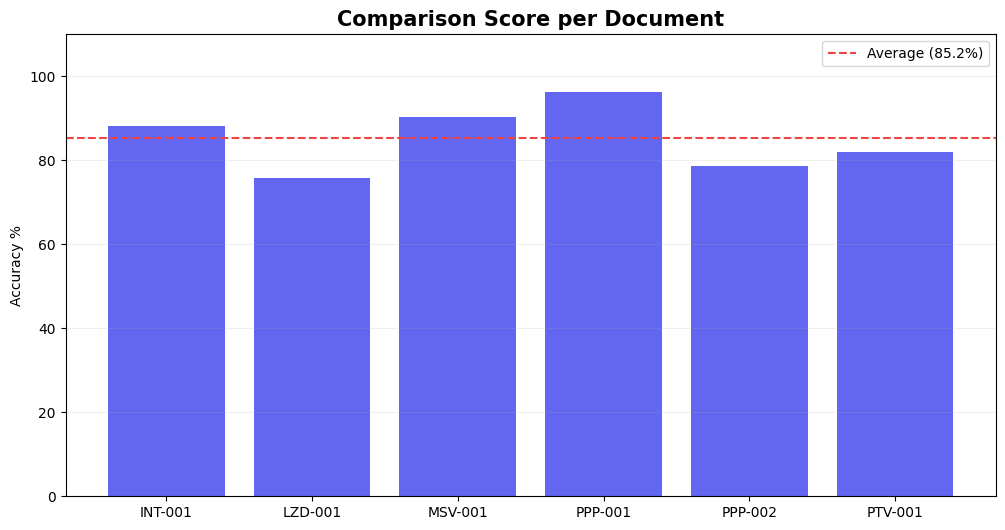

File,Score,Fields
INT-001,88.06%,14
LZD-001,75.85%,13
MSV-001,90.38%,12
PPP-001,96.29%,35
PPP-002,78.72%,23
PTV-001,81.97%,12


In [12]:
# FINAL BATCH SUMMARY
display(HTML("<h1 style='color: #1e293b; margin-top: 40px;'>Batch Processing Final Results</h1>"))

summary_df = pd.DataFrame(batch_summary)

if not summary_df.empty:
    # Aggregate Score
    avg_batch_score = summary_df['Score'].mean()
    
    display(HTML(f"""
    <div style='background: linear-gradient(135deg, #1e293b 0%, #334155 100%); color: white; padding: 30px; border-radius: 15px; margin-bottom: 30px;'>
        <h2 style='margin: 0; opacity: 0.8;'>Aggregate Accuracy</h2>
        <div style='font-size: 48px; font-weight: bold;'>{avg_batch_score:.2f}%</div>
        <div style='margin-top: 10px; font-size: 16px;'>Across {len(summary_df)} documents</div>
    </div>
    """))

    # Plotting Leaderboard
    plt.figure(figsize=(12, 6))
    plt.bar(summary_df['File'], summary_df['Score'], color='#6366f1')
    plt.axhline(y=avg_batch_score, color='#ef4444', linestyle='--', label=f'Average ({avg_batch_score:.1f}%)')
    plt.title("Comparison Score per Document", fontsize=15, fontweight='bold')
    plt.ylabel("Accuracy %")
    plt.ylim(0, 110)
    plt.legend()
    plt.grid(axis='y', alpha=0.2)
    plt.show()

    # Detailed Final Styler
    def final_score_style(val):
        color = '#16a34a' if val > 90 else '#eab308' if val > 75 else '#ef4444'
        return f'color: {color}; font-weight: bold;'

    # Display final results table
    display(HTML("<h3>Document Leaderboard</h3>"))
    display(summary_df.style.map(final_score_style, subset=['Score'])\
                      .format({"Score": "{:.2f}%"})\
                      .set_properties(**{'text-align': 'center', 'padding': '15px'})\
                      .hide(axis='index'))
else:
    print("No results to summarize.")

In [28]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import numpy as np

def load_json(filepath):
    """Load JSON file"""
    with open(filepath, 'r') as f:
        return json.load(f)

def flatten_json(obj, parent_key='', sep='.'):
    """Flatten nested JSON to key-value pairs"""
    items = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            if isinstance(v, (dict, list)):
                items.extend(flatten_json(v, new_key, sep=sep))
            else:
                items.append((new_key, v))
    elif isinstance(obj, list):
        for i, v in enumerate(obj):
            new_key = f"{parent_key}[{i}]"
            if isinstance(v, (dict, list)):
                items.extend(flatten_json(v, new_key, sep=sep))
            else:
                items.append((new_key, v))
    else:
        items.append((parent_key, obj))
    return items

def compare_keys(json1, json2):
    """Compare JSON files key by key"""
    flat1 = dict(flatten_json(json1))
    flat2 = dict(flatten_json(json2))
    
    all_keys = sorted(set(flat1.keys()) | set(flat2.keys()))
    
    comparison = []
    for key in all_keys:
        val1 = flat1.get(key, '—')
        val2 = flat2.get(key, '—')
        
        if key not in flat1:
            status = 'ADDED'
        elif key not in flat2:
            status = 'REMOVED'
        elif val1 != val2:
            status = 'MODIFIED'
        else:
            status = 'SAME'
        
        comparison.append({
            'key': key,
            'file1_value': val1,
            'file2_value': val2,
            'status': status
        })
    
    return comparison

def print_comparison_table(comparison):
    """Print detailed key-by-key comparison table"""
    print("\n" + "="*100)
    print("KEY-BY-KEY COMPARISON")
    print("="*100)
    print(f"{'Key':<40} {'File 1 Value':<25} {'File 2 Value':<25} {'Status':<10}")
    print("-"*100)
    
    status_symbols = {
        'ADDED': '✅',
        'REMOVED': '❌',
        'MODIFIED': '🔄',
        'SAME': '✓'
    }
    
    for item in comparison:
        key = item['key'][:38] + '..' if len(item['key']) > 40 else item['key']
        val1 = str(item['file1_value'])[:23] + '..' if len(str(item['file1_value'])) > 25 else str(item['file1_value'])
        val2 = str(item['file2_value'])[:23] + '..' if len(str(item['file2_value'])) > 25 else str(item['file2_value'])
        status = f"{status_symbols[item['status']]} {item['status']}"
        
        print(f"{key:<40} {val1:<25} {val2:<25} {status:<10}")
    
    print("="*100 + "\n")

def visualize_key_comparison(comparison):
    """Create detailed visualizations for key-by-key comparison"""
    # Calculate statistics
    stats = {
        'ADDED': sum(1 for item in comparison if item['status'] == 'ADDED'),
        'REMOVED': sum(1 for item in comparison if item['status'] == 'REMOVED'),
        'MODIFIED': sum(1 for item in comparison if item['status'] == 'MODIFIED'),
        'SAME': sum(1 for item in comparison if item['status'] == 'SAME')
    }
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Summary Bar Chart
    ax1 = fig.add_subplot(gs[0, :])
    colors = {'ADDED': '#28a745', 'REMOVED': '#dc3545', 'MODIFIED': '#ffc107', 'SAME': '#6c757d'}
    bars = ax1.bar(stats.keys(), stats.values(), 
                   color=[colors[k] for k in stats.keys()], 
                   alpha=0.7, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax1.set_title('Key-by-Key Comparison Summary', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 2. Pie Chart
    ax2 = fig.add_subplot(gs[1, 0])
    non_zero_stats = {k: v for k, v in stats.items() if v > 0}
    if non_zero_stats:
        colors_pie = [colors[k] for k in non_zero_stats.keys()]
        wedges, texts, autotexts = ax2.pie(
            non_zero_stats.values(),
            labels=non_zero_stats.keys(),
            autopct='%1.1f%%',
            colors=colors_pie,
            startangle=90,
            textprops={'fontweight': 'bold'}
        )
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(10)
        ax2.set_title('Distribution of Changes', fontsize=12, fontweight='bold')
    
    # 3. Change Percentage
    ax3 = fig.add_subplot(gs[1, 1])
    total_keys = len(comparison)
    changed_keys = stats['ADDED'] + stats['REMOVED'] + stats['MODIFIED']
    change_pct = (changed_keys / total_keys * 100) if total_keys > 0 else 0
    
    ax3.text(0.5, 0.6, f'{change_pct:.1f}%', 
             ha='center', va='center', fontsize=48, fontweight='bold',
             color='#ff6b6b' if change_pct > 50 else '#ffc107' if change_pct > 20 else '#28a745')
    ax3.text(0.5, 0.3, 'Keys Changed', 
             ha='center', va='center', fontsize=14, color='#333')
    ax3.text(0.5, 0.15, f'({changed_keys} out of {total_keys} keys)', 
             ha='center', va='center', fontsize=10, color='#666')
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis('off')
    
    # 4. Key Status Heatmap (sample of first 20 keys)
    ax4 = fig.add_subplot(gs[2, :])
    sample_size = min(20, len(comparison))
    sample_comparison = comparison[:sample_size]
    
    status_map = {'ADDED': 1, 'REMOVED': 2, 'MODIFIED': 3, 'SAME': 0}
    status_values = [status_map[item['status']] for item in sample_comparison]
    
    # Create horizontal bars for each key
    y_pos = np.arange(len(sample_comparison))
    for i, item in enumerate(sample_comparison):
        color = colors[item['status']]
        ax4.barh(i, 1, color=color, alpha=0.7, edgecolor='black', linewidth=1)
        
        # Add key name
        key_text = item['key'][:35] + '...' if len(item['key']) > 38 else item['key']
        ax4.text(-0.05, i, key_text, ha='right', va='center', fontsize=8)
    
    ax4.set_yticks([])
    ax4.set_xlim(-0.5, 1.1)
    ax4.set_ylim(-0.5, len(sample_comparison) - 0.5)
    ax4.set_xlabel('Status', fontsize=10, fontweight='bold')
    ax4.set_title(f'Key Status Overview (Showing {sample_size} of {len(comparison)} keys)', 
                  fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    
    # Legend
    legend_elements = [mpatches.Patch(facecolor=colors[k], edgecolor='black', label=k) 
                      for k in ['ADDED', 'REMOVED', 'MODIFIED', 'SAME']]
    ax4.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    plt.savefig('json_key_comparison.png', dpi=300, bbox_inches='tight')
    print("Visualization saved as 'json_key_comparison.png'")
    plt.show()

def generate_summary(comparison):
    """Generate summary statistics"""
    stats = {
        'ADDED': [],
        'REMOVED': [],
        'MODIFIED': [],
        'SAME': []
    }
    
    for item in comparison:
        stats[item['status']].append(item['key'])
    
    print("\n" + "="*100)
    print("SUMMARY")
    print("="*100)
    print(f"Total Keys Compared: {len(comparison)}")
    print(f"✅ Added Keys: {len(stats['ADDED'])}")
    print(f"❌ Removed Keys: {len(stats['REMOVED'])}")
    print(f"🔄 Modified Keys: {len(stats['MODIFIED'])}")
    print(f"✓ Unchanged Keys: {len(stats['SAME'])}")
    
    if stats['ADDED']:
        print(f"\nAdded Keys: {', '.join(stats['ADDED'][:5])}" + 
              (f" ... and {len(stats['ADDED']) - 5} more" if len(stats['ADDED']) > 5 else ""))
    
    if stats['REMOVED']:
        print(f"Removed Keys: {', '.join(stats['REMOVED'][:5])}" + 
              (f" ... and {len(stats['REMOVED']) - 5} more" if len(stats['REMOVED']) > 5 else ""))
    
    if stats['MODIFIED']:
        print(f"Modified Keys: {', '.join(stats['MODIFIED'][:5])}" + 
              (f" ... and {len(stats['MODIFIED']) - 5} more" if len(stats['MODIFIED']) > 5 else ""))
    
    print("="*100 + "\n")



SUMMARY
Total Keys Compared: 1
✅ Added Keys: 0
❌ Removed Keys: 0
🔄 Modified Keys: 1
✓ Unchanged Keys: 0
Modified Keys: natural_text


KEY-BY-KEY COMPARISON
Key                                      File 1 Value              File 2 Value              Status    
----------------------------------------------------------------------------------------------------
natural_text                             <logo>Lazada</logo>

TA.. <logo>Lazada</logo>

TA.. 🔄 MODIFIED

Visualization saved as 'json_key_comparison.png'


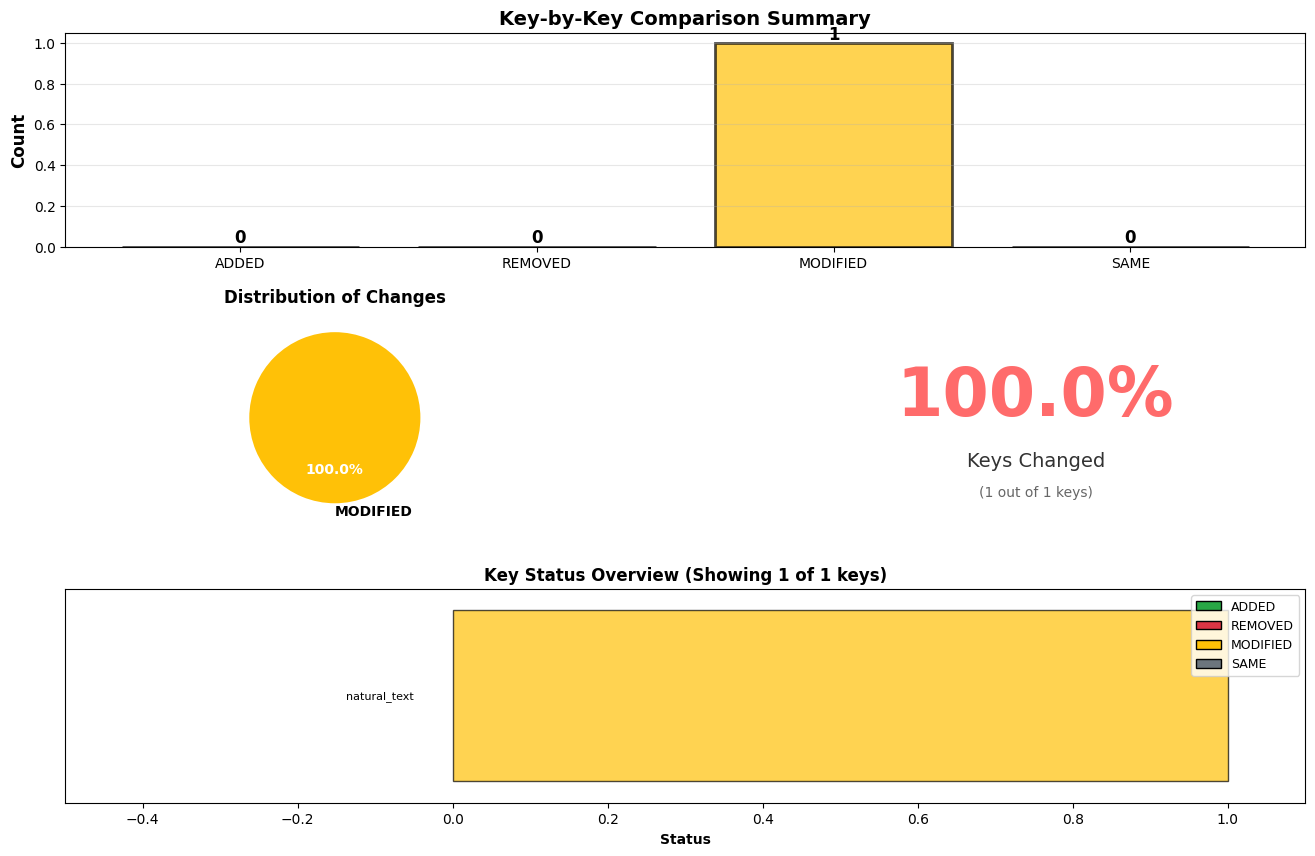

In [30]:
# Example usage - replace with your file paths
file1_path = "/Users/pat/Desktop/custom_FM/working/no_prompt.json"
file2_path = "/Users/pat/Desktop/custom_FM/working/with_prompt.json"
    
try:
      # Load JSON files
      json1 = load_json(file1_path)
      json2 = load_json(file2_path)
      
      # Compare key by key
      comparison = compare_keys(json1, json2)
      
      # Generate outputs
      generate_summary(comparison)
      print_comparison_table(comparison)
      visualize_key_comparison(comparison)
      
except FileNotFoundError:
      print("Creating sample JSON files for demonstration...\n")
      
      # Create sample files with nested structure
      sample1 = {
      "product": {
            "name": "Laptop Pro",
            "price": 1200,
            "specs": {
                  "cpu": "Intel i7",
                  "ram": "16GB",
                  "storage": "512GB SSD"
            }
      },
      "stock": 50,
      "tags": ["electronics", "computers"]
      }
      
      sample2 = {
      "product": {
            "name": "Laptop Pro",
            "price": 1350,
            "specs": {
                  "cpu": "Intel i9",
                  "ram": "16GB",
                  "storage": "1TB SSD",
                  "gpu": "RTX 3060"
            }
      },
      "stock": 45,
      "tags": ["electronics", "computers", "gaming"]
      }
      
      with open("file1.json", "w") as f:
            json.dump(sample1, f, indent=2)
      with open("file2.json", "w") as f:
            json.dump(sample2, f, indent=2)
      
      print("✓ Sample files created: file1.json and file2.json")
      print("Run the script again to see the key-by-key comparison!\n")

except json.JSONDecodeError as e:
      print(f"Error parsing JSON: {e}")
except Exception as e:
      print(f"Unexpected error: {e}")

In [14]:
old_path = "/Users/pat/Desktop/custom_FM/working/no_prompt.json"
new_path = "/Users/pat/Desktop/custom_FM/working/with_prompt.json"

old_json = load_json(old_path)
new_json = load_json(new_path)

diffs = diff_json(old_json, new_json)

print(f"Total diffs: {len(diffs)}")
show_diff_table(diffs)
show_side_by_side(old_json, new_json, diffs)


Total diffs: 1


,type,path,old,new
0,changed,natural_text,<logo>Lazada</logo>\n\nTAX INVOICE / RECEIPT\n...,<logo>Lazada</logo>\n\nTAX INVOICE / RECEIPT\n...


In [5]:
old_path = "/Users/pat/Desktop/custom_FM/working/no_prompt.json"
new_path = "/Users/pat/Desktop/custom_FM/working/with_prompt.json"

old_json = load_json(old_path)
new_json = load_json(new_path)

diffs = diff_json(old_json, new_json)

pretty_print_diffs(diffs)


✏️  natural_text: <logo>Lazada</logo>

TAX INVOICE / RECEIPT

LAZADA LIMITED (HEAD OFFICE)
29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton,
Vadhana, Bangkok, 10110
Tax ID: 0105555040244

ชื่อลูกค้า / Customer : เลขที่/No.
ที่อยู่ / Address : Date 26/01/2023
กรุงเทพมหานคร/ Bangkok, 10230
Ref. Order No.: 649344100179434

<table border="1">
<tr>
    <td>ลำดับ Item</td>
    <td>Description</td>
    <td>จำนวน Quantity</td>
    <td>หน่วยละ Unit price</td>
    <td>จำนวนเงิน Amount</td>
</tr>
<tr>
    <td>1</td>
    <td>Certainly ผ้าอ้อมผู้ใหญ่แบบแพ็ค เชอร์เทนส์ อีซี่เทป Easy Taperedราคาประหยัด สิ้ง Super Save ไซส์ L 96 ชิ้น</td>
    <td>1</td>
    <td>1,269.00</td>
    <td>1,269.00</td>
</tr>
</table>

คูปอง/ส่วนลด Coupon/Discount : 0.00
มูลค่าสินค้า (ก่อนภาษีมูลค่าเพิ่ม) Total value of goods/services (Excluded VAT) : 1,185.98
ภาษีมูลค่าเพิ่ม 7% / VAT 7% : 83.02
มูลค่าสินค้าบริการรวมภาษีมูลค่าเพิ่ม Total value of Goods/Services (Included VAT) : 1,269.00
คูปองเงินสด Store

In [6]:
pretty_print_diffs(diffs)

✏️  natural_text: <logo>Lazada</logo>

TAX INVOICE / RECEIPT

LAZADA LIMITED (HEAD OFFICE)
29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton,
Vadhana, Bangkok, 10110
Tax ID: 0105555040244

ชื่อลูกค้า / Customer : เลขที่/No.
ที่อยู่ / Address : Date 26/01/2023
กรุงเทพมหานคร/ Bangkok, 10230
Ref. Order No.: 649344100179434

<table border="1">
<tr>
    <td>ลำดับ Item</td>
    <td>Description</td>
    <td>จำนวน Quantity</td>
    <td>หน่วยละ Unit price</td>
    <td>จำนวนเงิน Amount</td>
</tr>
<tr>
    <td>1</td>
    <td>Certainly ผ้าอ้อมผู้ใหญ่แบบแพ็ค เชอร์เทนส์ อีซี่เทป Easy Taperedราคาประหยัด สิ้ง Super Save ไซส์ L 96 ชิ้น</td>
    <td>1</td>
    <td>1,269.00</td>
    <td>1,269.00</td>
</tr>
</table>

คูปอง/ส่วนลด Coupon/Discount : 0.00
มูลค่าสินค้า (ก่อนภาษีมูลค่าเพิ่ม) Total value of goods/services (Excluded VAT) : 1,185.98
ภาษีมูลค่าเพิ่ม 7% / VAT 7% : 83.02
มูลค่าสินค้าบริการรวมภาษีมูลค่าเพิ่ม Total value of Goods/Services (Included VAT) : 1,269.00
คูปองเงินสด Store